Hyperparameters definition and loading of CIFAR100 from pytorch torchvision

In [1]:
from comet_ml import Experiment
import torch
import torchvision
import torchvision.transforms as transforms

train_portion = 0.7

#controllare che len(val) è len(train)

#hyperparameters
batch_size = 250

#pad_totensor_transform = transforms.Compose([transforms.Pad(2), transforms.ToTensor()]) # does the padding, images 32x32 become 36x36 (symmetric increase) so that are divisible by three and patches are 12x12
pad_totensor_transform = transforms.Compose([transforms.ToTensor()]) #no pad, no normalization

root = './cifar100_data' #if not in lab
root = '../datasets/cifar10'


dataset = torchvision.datasets.CIFAR10(root=root, train=True, transform=pad_totensor_transform, download=True)
train_subset, val_subset = torch.utils.data.random_split(dataset, [int(train_portion*len(dataset)), len(dataset) - int(train_portion*len(dataset))], generator=torch.Generator().manual_seed(1))
test_dataset = torchvision.datasets.CIFAR10(root=root, train=False, transform=pad_totensor_transform)


train_loader = torch.utils.data.DataLoader(dataset=train_subset, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(dataset=val_subset, shuffle=False, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print(f"BATCH SIZE: {batch_size}")
print(f"Tran subset len: {len(train_subset)}")
print(f"Tran loader len: {len(train_loader)}")
print(f"Test: {len(train_subset)/batch_size}")

print(f"Val subset len: {len(val_subset)}")
print(f"Val subset len: {len(val_loader)}")
print(f"Test: {len(val_subset)/batch_size}")


print(f"Test subset len: {len(test_dataset)}")
print(f"Test subset len: {len(test_loader)}")
print(f"Test: {len(test_dataset)/batch_size}")


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../datasets/cifar10/cifar-10-python.tar.gz to ../datasets/cifar10
BATCH SIZE: 250
Tran subset len: 35000
Tran loader len: 140
Test: 140.0
Val subset len: 15000
Val subset len: 60
Test: 60.0
Test subset len: 10000
Test subset len: 40
Test: 40.0


torch.Size([250, 3, 32, 32]) torch.Size([250])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


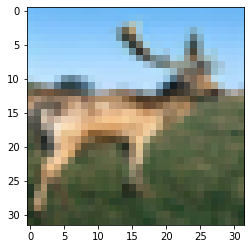

In [2]:
#test dataloader

examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

import matplotlib.pyplot as plt

img_sample = samples[0]
print(img_sample.shape)
print(img_sample.shape)
plt.imshow(img_sample.permute(1, 2, 0))
plt.show()

**Training loop**

In [3]:
#device

In [4]:
#!conda install einops
from mlp_mixer import *
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import json

In [5]:
def get_accuracy(predicted, true_labels):
    predicted = torch.argmax(predicted.cpu(), dim=1)
    return accuracy_score(predicted, true_labels.cpu()) #forse questi passaggi a cpu non sono molto efficienti..

def generate_folder():
    import time
    import os
    import os.path
    datetime = time.strftime("%Y%m%d-%H%M%S")

    folder = f"./models/{datetime}/"
    os.chdir(".")
    print("current dir is: %s" % (os.getcwd()))

    if os.path.isdir(folder):
        print("Exists")
    else:
        os.mkdir(folder)
    return folder

#def save_model(model, path):
#    filename = path + f"{filename}.pth"
#    print(filename)
#    torch.save(model.state_dict(), filename)    

In [6]:

experiment = Experiment(
    api_key="xX6qWBFbiOreu0W3IrO14b9nB",
    project_name="mlp-mixer",
    workspace="wedrid",
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

image_width_height = img_sample.shape[1]
patch_dims = 4
# variable_name = value #paper value
n_channels = 32 #128 #256 #100 #512 #embed dim
loss_func = nn.CrossEntropyLoss()
learning_rate = 0.001
num_layers = 3 #8
mlp_dc_dimension = 128 #512 #1024 #2048 # dc è la dimensione del channel mixing (l'ultimo mlp)
mlp_ds_dimension = 32 #64 #128 #256 # ds è la dimensione del token mixing (il primo)

model = MLP_mixer(img_h_w=image_width_height, patch_dim=patch_dims, n_channels=n_channels, num_mixers_layers=num_layers,
    hidden_dim_mlp_token=mlp_ds_dimension, hidden_dim_mlp_channel=mlp_dc_dimension) #in this case 2 patches 16x16
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=1e-5) 

num_epochs = 200
steps_total = len(train_loader)

#ATTENZIONE: CAMBIARE IPERPARAMETRI ***PRIMAAAA*** DEL DICT SUCCESSIVO

hyper_params = {
    "dataset": root,
    "comment": 'added weight decay',
    "train_size": len(train_loader),
    "validation_size": len(val_loader),
    "learning_rate": learning_rate,
    "epochs": num_epochs,
    "steps": steps_total,
    "batch_size": batch_size,
    "image_width_and_height": image_width_height,
    "patch_width_and_height": patch_dims,
    "hidden_dim_size (n_channels)": n_channels,
    "number_of_layers": num_layers,
    "mlp_dc_dimension": mlp_dc_dimension,
    "mlp_ds_dimension": mlp_ds_dimension
}

experiment.log_parameters(hyper_params)
model_path = generate_folder()
with open(model_path+"/params.json", "w") as file:
    json.dump(hyper_params, file, indent=4)

model.to(device)
# training loop
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_accuracy = 0
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        # [100, 3, 36, 36] is what is returned by iterator
        images = images.to(device)
        labels = labels.to(device)
        
        # forward pass
        predicted = model(images)
        loss = loss_func(predicted, labels)
        train_accuracy += get_accuracy(predicted, labels)

        # backwards pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if False and (i+1) % 100:
            print(f'epoch: {epoch+1} of {num_epochs}, step {i+1} of {steps_total}, loss = {loss.item():.4f}')
    print(f"Loss of epoch {epoch+1}: {loss.item():.4f}")
    train_accuracy /= len(train_loader)
    #print(f"TRAIN LOADER LENGTH: {len(train_loader)}")
    experiment.log_metric("train epoch loss", loss.item(), step=epoch)
    experiment.log_metric("mean train epoch accuracy", train_accuracy, step=epoch)
    # validation
    with torch.no_grad():
        model.eval()
        val_accuracy = 0
        temp = 0
        for i, (images, labels) in enumerate(tqdm(val_loader)): #numero esempi/batchsize TODO check
            # [100, 3, 36, 36] is what is returned by iterator
            images = images.to(device)
            labels = labels.to(device)
            
            # forward pass
            predicted = model(images)
            loss = loss_func(predicted, labels)
            val_accuracy += get_accuracy(predicted, labels)
        #print(f"Lenght val loader: {len(val_loader)}, counter: {temp}")
        val_accuracy /= len(val_loader) 
        experiment.log_metric("val epoch loss", loss.item(), step=epoch)
        experiment.log_metric("mean val epoch accuracy", val_accuracy, step=epoch)
    
    if epoch % 20 == 0:
        torch.save(model.state_dict(), model_path + f"checkpoint_epch_{epoch}.pth")
torch.save(model.state_dict(), model_path + f"final.pth")


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wedrid/mlp-mixer/c8f63d2835364b6b8255425dea82a852



current dir is: /mnt/5687e6b2-1adf-4c49-82ce-c30e45a94bfd/ewg7060776/Vit_vs_mlp_mixer/mlp_mixer


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 1: 1.7940


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 2: 1.4457


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 3: 1.4150


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 4: 1.4746


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 5: 1.2476


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 6: 1.1177


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 7: 1.0219


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 8: 1.2588


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 9: 1.1328


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 10: 1.0932


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 11: 1.0917


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 12: 1.1304


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 13: 0.9830


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 14: 0.9416


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 15: 1.0343


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 16: 0.9281


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 17: 0.9472


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 18: 0.8489


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 19: 0.9059


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 20: 0.8171


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 21: 0.9326


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 22: 0.8607


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 23: 0.8602


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 24: 0.8844


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 25: 0.8959


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 26: 0.7992


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 27: 0.8405


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 28: 0.6575


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 29: 0.7140


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 30: 0.6508


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 31: 0.7342


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 32: 0.7406


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 33: 0.7639


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 34: 0.6848


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 35: 0.6684


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 36: 0.7027


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 37: 0.6545


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 38: 0.5550


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 39: 0.6465


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 40: 0.5006


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 41: 0.5926


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 42: 0.5300


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 43: 0.5422


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 44: 0.6154


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 45: 0.5457


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 46: 0.4393


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 47: 0.5122


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 48: 0.5566


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 49: 0.4555


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 50: 0.4437


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 51: 0.4721


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
if False: 
    examples = iter(train_loader)
    images, labels = examples.next()

    # metrics trial
    images = images.to(device)
    labels = labels.to(device)

    # forward pass
    outputs = model(images)
    loss = loss_func(outputs, labels)

    #da mettere nel ciclo
    print(outputs.shape)

    #####
    predicted = torch.argmax(outputs, dim=1)
    accuracy = accuracy_score(predicted, labels)
    print(f'Accuracy {accuracy}')
    #####
    print(predicted.shape)
    print(predicted)
